# Image Segmentation using U-Net and Kaggle Carvana Data

All this is the same code as before (fast.ai lesson 14 carvana notebook).

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Send notifications to mobile
# Note, this is for my own use case. So, for you, don't run this cell.
from my_scripts.ntfy.notification_callback import *

notif_cb = NotificationCallback()

Import libraries:

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json

In [ ]:
# Enable the following line if you have more than 1 GPU
# torch.cuda.set_device(0)

In [4]:
torch.backends.cudnn.benchmark = True

## Data

Setup directory and file paths:

In [5]:
PATH = Path('data/carvana')
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH / MASKS_FN)
meta_csv = pd.read_csv(PATH / META_FN)

A helper function for showing images:

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [7]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 64
nw = 16

In [ ]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 128
bs = 64
nw = 16

In [8]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y = y
        assert(len(fnames) == len(y))
        super().__init__(fnames, transform, path)

    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))

    def get_c(self): return 0

In [9]:
x_names = np.array([Path(TRAIN_DN) / o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN) / f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [10]:
val_idxs = list(range(1008))
((val_x, trn_x), (val_y, trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [11]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [12]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)  # num_workers depends on batch size
denorm = md.trn_ds.denorm

In [13]:
x, y = next(iter(md.trn_dl))

In [14]:
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 128, 128]))

## Simple upsample

At the start, I've got a simple upsample version just to show you again the non U-net version. This time, I'm going to add in something called the **dice metric**. Dice is very similar, as you see, to Jaccard or I over U. It's just a minor difference. It's basically intersection over union with a minor tweak. The reason we are going to use dice is that's the metric that Kaggle competition used and it's a little bit harder to get a high dice score than a high accuracy because it's really looking at what the overlap of the correct pixels are with your pixels. But it's pretty similar.

So in the Kaggle competition, people that were doing okay were getting about 99.6 dice and the winners were about 99.7 dice.

In [15]:
f = resnet34
cut, lr_cut = model_meta[f]

Base is our base network:

In [16]:
def get_base():
    """Basically removes everything from the adaptive pooling onwards, so that gives us back
    the backbone of ResNet34.
    """
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

F1/Dice vs IoU/Jaccard score. [Dice formula](https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou).

In [17]:
def dice(pred, targs):
    pred = (pred > 0).float()
    return 2. * (pred * targs).sum() / (pred + targs).sum()

Here is our standard upsample:

In [18]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)

    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [19]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn # resnet
        self.features = nn.Sequential(
            rn, nn.ReLU(),
            StdUpsample(512, 256),
            StdUpsample(256, 256),
            StdUpsample(256, 256),
            StdUpsample(256, 256),
            nn.ConvTranspose2d(256, 1, 2, stride=2))

    def forward(self, x): return self.features(x)[:, 0]

In [20]:
class UpsampleModel():
    def __init__(self, model, name='upsample'):
        self.model, self.name = model, name
    
    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]

In [21]:
m_base = get_base()

In [30]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

In [31]:
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = nn.BCEWithLogitsLoss()
learn.metrics = [accuracy_thresh(0.5), dice]

In [32]:
learn.freeze_to(1)

In [24]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('BatchNorm2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_para

 84%|████████▍ | 54/64 [00:19<00:03,  2.70it/s, loss=2.81] CPU times: user 25.4 s, sys: 4.7 s, total: 30.1 s
Wall time: 20.3 s


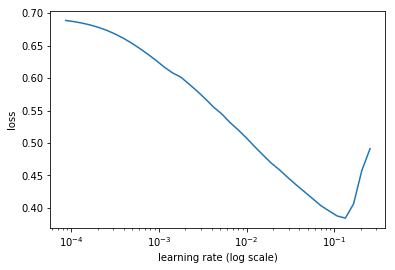

In [25]:
%%time
learn.lr_find()
learn.sched.plot()

In [22]:
lr = 4e-2
wd = 1e-7
lrs = np.array([lr / 100, lr / 10, lr]) / 2

In [27]:
%time learn.fit(lr, 1, wds=wd, cycle_len=4, use_clr=(20, 8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.115094   0.052829   0.977156   0.946632  
    1      0.060572   0.041022   0.981844   0.958449        
    2      0.041211   0.037313   0.981443   0.960839        
    3      0.033257   0.029371   0.986961   0.971081        
CPU times: user 2min 1s, sys: 21.1 s, total: 2min 23s
Wall time: 1min 38s


[array([0.02937]), 0.9869610014415923, 0.9710806340169884]

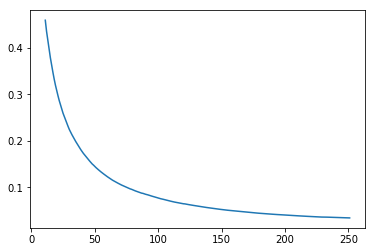

In [28]:
learn.sched.plot_loss()

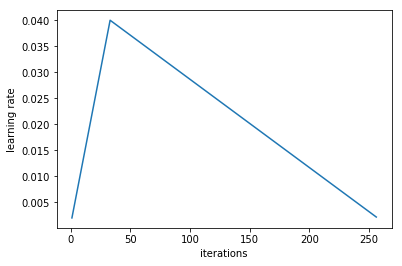

In [29]:
learn.sched.plot_lr()

In [30]:
learn.save('tmp')

In [ ]:
learn.load('tmp')

In [35]:
learn.unfreeze()
learn.bn_freeze(True)

In [33]:
learn.fit(lrs, 1, cycle_len=4, use_clr=(20, 8))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.030218   0.028607   0.988389   0.972355  
    1      0.026548   0.02659    0.988868   0.974199        
    2      0.024496   0.025141   0.989952   0.975959        
    3      0.022905   0.024065   0.990201   0.977141        


[array([0.02407]), 0.9902006482321118, 0.9771410902235166]

Now we can check our dice metric. You can see on dice metric, we are getting around 97.7 at 128x128. So that's not great.

In [37]:
learn.save('128')

In [36]:
learn.load('128')

Test the model by running predictions.

In [40]:
x, y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

Predicted version of the mask:

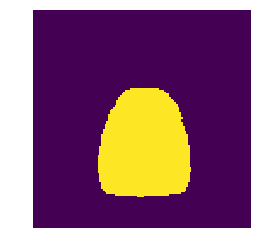

In [41]:
show_img(py[0] > 0)

That is more like a blob than car-like!

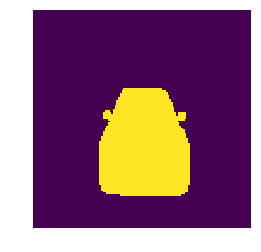

In [42]:
show_img(y[0])

## U-net (ish)

I'm calling it U-net (ish) because as per usual I'm creating my own somewhat hacky version — trying to keep things as similar to what you're used to as possible and doing things that I think makes sense.

So there should be plenty of opportunity for you to at least make this more authentically U-net. There's a few differences. But one of the things is because I want to take advantage of transfer learning — that means I can't quite use U-Net.

What if you create the U-Net down path and then add a classifier on the end and then train that on ImageNet. For now though, we don't have that yet. So we are going to use ResNet.

In [23]:
class SaveFeatures():
    features = None

    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output): self.features = output

    def remove(self): self.hook.remove()

`UnetBlock` works like this:

- `up_in` : This many are coming up from the previous layer
- `x_in` : This many are coming across (hence `x`) from the downward path
- `n_out` : The amount we want coming out

What I do is, we're going to create a certain amount of convolutions from the upward path and a certain amount from the cross path, and so I'm going to be concatenating them together so let's divide the number we want out by 2. And so we are going to have our cross convolution take our cross path and create number out divided by 2 (`n_out//2`). And then the upward path is going to be a `ConvTranspose2d` because we want to increase/upsample. Again here, we've got the number out divided by 2 (`up_out`), then at the end, I just concatenate those together.

So I've got an upward sample, I've got a cross convolution, I can concatenate the two together. That's all a `UnetBlock` is:

In [24]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out // 2
        self.x_conv = nn.Conv2d(x_in, x_out, 1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p) # up path
        x_p = self.x_conv(x_p) # cross path
        cat_p = torch.cat([up_p, x_p], dim=1) # dim 1 means concat from means left to right
        return self.bn(F.relu(cat_p))

We are going to take that ResNet34 backbone and turn it into a, I call it a, Unet34. So what that's going to do is it's going to save that ResNet that we passed in (`rn`) and then we are going to use a forward hook (`SaveFeatures`) just like before to save the results at the 2nd, 4th, 5th, and 6th blocks which as before is the layers before each stride 2 convolution.

Then we are going to create a bunch of these things we are calling `UnetBlock`. We need to tell `UnetBlock` how many things are coming from the previous layer we are upsampling, how many are coming across, and then how many do we want to come out. The amount coming across is entirely defined by whatever the base network was — whatever the downward path was, we need that many layers. So this is a little bit awkward:

In [25]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn # the passed in encoder, example ResNet34
        self.sfs = [SaveFeatures(rn[i]) for i in [2, 4, 5, 6]]
        # calculating connections and channels suck!
        self.up1 = UnetBlock(512, 256, 256)
        self.up2 = UnetBlock(256, 128, 256)
        self.up3 = UnetBlock(256, 64, 256)
        self.up4 = UnetBlock(256, 64, 256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self, x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:, 0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In my forward path, I need to pass to the forward of the `UnetBlock` the upward path and the cross path. The upward path is just whatever I am up to so far. But then the cross path is whatever the activations are that I stored on the way down. So as I come up, it's the last set of saved features that I need first. And as I gradually keep going up farther and farther, eventually it's the first set of features.

In [26]:
class UnetModel():
    def __init__(self, model, name='unet'):
        self.model, self.name = model, name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut])) # type of lr_cut is int. val is 6
        return lgs + [children(self.model)[1:]]

Base is our base network and that was defined back up in the U-Net section.

In [37]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [38]:
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = nn.BCEWithLogitsLoss() # Binary Cross Entropy with logits loss
learn.metrics = [accuracy_thresh(0.5), dice] # dice is like autoencoder reconstruction loss

In [51]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

In [ ]:
[o.features.size() for o in m.sfs]

In [40]:
learn.freeze_to(1)

### Train

 89%|████████▉ | 57/64 [00:20<00:02,  2.80it/s, loss=1.57] 

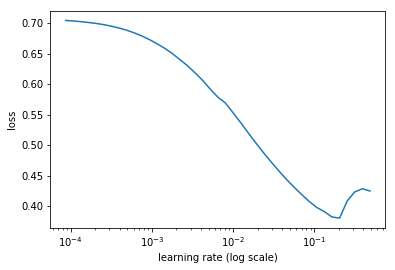

In [55]:
learn.lr_find()
learn.sched.plot()

In [27]:
lr = 4e-2
wd = 1e-7

lrs = np.array([lr / 100, lr / 10, lr])

In [58]:
%time learn.fit(lr, 1, wds=wd, cycle_len=8, use_clr=(5, 8), callbacks=[notif_cb])

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.066708   0.030094   0.986666   0.970317  
    1      0.03581    0.0268     0.987201   0.973306        
    2      0.026499   0.022651   0.991143   0.978611        
    3      0.022736   0.024409   0.98834    0.975742        
    4      0.02067    0.019966   0.991698   0.98108         
    5      0.019395   0.019475   0.991706   0.98148         
    6      0.018421   0.01992    0.990994   0.980779        
    7      0.017531   0.018478   0.992754   0.982734        
CPU times: user 4min 2s, sys: 40.2 s, total: 4min 42s
Wall time: 3min 21s


[array([0.01848]), 0.9927536495148189, 0.982733676754673]

In [59]:
learn.save('128urn-tmp')

In [42]:
learn.load('128urn-tmp')

In [43]:
learn.unfreeze()
learn.bn_freeze(True)

In [62]:
%time learn.fit(lrs / 4, 1, wds=wd, cycle_len=20, use_clr=(20, 10), callbacks=[notif_cb])

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.016101   0.017776   0.992521   0.983324  
    1      0.015925   0.018096   0.992984   0.983291        
    2      0.018197   0.047329   0.987563   0.967537        
    3      0.017198   0.017029   0.993005   0.984194        
    4      0.015525   0.016861   0.993109   0.984405        
    5      0.014776   0.016335   0.993529   0.984962        
    6      0.014414   0.016253   0.993712   0.985091        
    7      0.014118   0.016177   0.993633   0.98518         
    8      0.013989   0.01612    0.993777   0.985277        
    9      0.013846   0.016417   0.993895   0.985105        
    10     0.01364    0.015978   0.993756   0.985407        
    11     0.013568   0.015831   0.993784   0.985544        
    12     0.013413   0.015774   0.993833   0.985651        
    13     0.013295   0.015836   0.993919   0.985671        
    14     0.013165   0.015741   0.99394    0.985754        
    15     0.013016   0.015676

[array([0.01543]), 0.9939509204455784, 0.9860580409134332]

There are some more tricks we can do to make this a little bit better, but this is a good stuff. So the simple upsampling approach looked horrible and had a dice of .977. A U-Net with everything else identical except we've now got these `UnetBlock`s has a dice of .986! That's like a significant error improvement with everything else exactly the same. And more the point, you can look at it.

In [63]:
learn.save('128urn-0')

In [44]:
learn.load('128urn-0')

In [65]:
x, y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

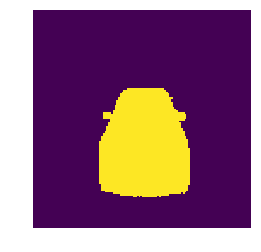

In [66]:
show_img(py[0] > 0)

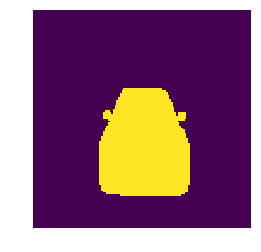

In [67]:
show_img(y[0])

This is actually looking somewhat car-like compared to our non-U-Net equivalent which is just a blob. Because trying to do this through down and up paths — it's just asking too much. Where else, when we actually provide the downward path pixels at every point, it can actually start to create something car-ish.

At the end of that, we'll do `m.close` to remove those `sfs.features` taking up GPU memory.

In [45]:
m.close()

## 512x512

Go to a higher size, smaller batch size:

In [43]:
sz = 512
bs = 16

In [44]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None) # num_workers depends on batch size
denorm = md.trn_ds.denorm

In [45]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [46]:
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = nn.BCEWithLogitsLoss()
learn.metrics = [accuracy_thresh(0.5),dice]

In [47]:
learn.freeze_to(1)

In [48]:
learn.load('128urn-0')

In [75]:
%time learn.fit(lr, 1, wds=wd, cycle_len=5, use_clr=(5, 5), callbacks=[notif_cb])

epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.017611   0.014881   0.994306   0.986385  
    1      0.016555   0.014923   0.994269   0.98626           
    2      0.013905   0.01462    0.99486    0.986607          
    3      0.012831   0.012048   0.995147   0.988891          
    4      0.011694   0.01176    0.995541   0.989296          
CPU times: user 28min 2s, sys: 3min 23s, total: 31min 26s
Wall time: 23min 2s


[array([0.01176]), 0.9955409405723451, 0.9892959675710081]

**Analysis of result**

You can see the dice coefficients really going up but that doesn't gets us to .99.

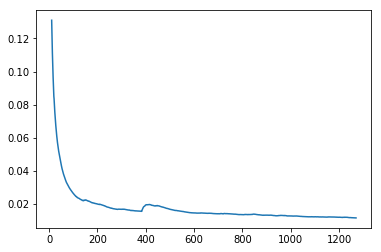

In [77]:
learn.sched.plot_loss()

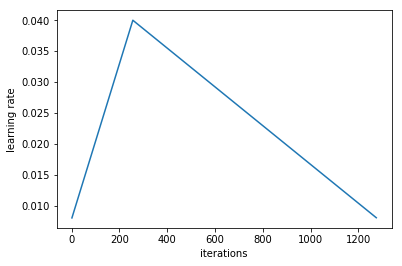

In [78]:
learn.sched.plot_lr()

In [76]:
learn.save('512urn-tmp')

In [79]:
%time learn.fit(lr, 1, wds=wd, cycle_len=5, use_clr=(5, 5))

epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.014255   0.013675   0.994578   0.987456  
    1      0.014982   0.013291   0.994674   0.987907          
    2      0.013134   0.013242   0.995201   0.987754          
    3      0.012322   0.011949   0.995057   0.988967          
    4      0.011523   0.011415   0.995349   0.989528          
CPU times: user 27min 58s, sys: 3min 17s, total: 31min 15s
Wall time: 22min 45s


[array([0.01141]), 0.9953489682031056, 0.98952767819588]

In [80]:
%time learn.fit(lr, 1, wds=wd, cycle_len=8, use_clr=(20, 8))

epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.013183   0.017253   0.992196   0.983875  
    1      0.014358   0.012795   0.995054   0.988391          
    2      0.012857   0.012711   0.994946   0.988293          
    3      0.012494   0.012167   0.995214   0.988786          
    4      0.011796   0.011778   0.995447   0.989214          
    5      0.011607   0.011574   0.995224   0.989329          
    6      0.010983   0.010902   0.995638   0.989993          
    7      0.010343   0.010676   0.995724   0.990229          
CPU times: user 43min 54s, sys: 5min 4s, total: 48min 59s
Wall time: 35min 41s


[array([0.01068]), 0.9957240573943608, 0.990229018171244]

In [49]:
%time learn.fit(lr, 1, wds=wd, cycle_len=15, use_clr=(20, 15))

epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.02038    0.017019   0.993581   0.984605  
    1      0.015413   0.021796   0.99317    0.982386          
    2      0.013446   0.012829   0.995016   0.988377          
    3      0.013066   0.01274    0.995009   0.988459          
    4      0.016879   0.018553   0.99317    0.984035          
    5      0.012883   0.012582   0.995218   0.988506          
    6      0.011988   0.011866   0.995196   0.989116          
    7      0.011684   0.011807   0.995111   0.989118          
    8      0.011723   0.011681   0.995363   0.989368          
    9      0.011111   0.011305   0.99548    0.989674          
    10     0.0111     0.010907   0.995556   0.989962          
    11     0.010632   0.011047   0.995633   0.989969          
    12     0.010149   0.010644   0.995908   0.99022           
    13     0.009861   0.010494   0.995976   0.990494           
    14     0.009324   0.010202   0.995999   0.990774          

[array([0.0102]), 0.9959987950703454, 0.9907739180715136]

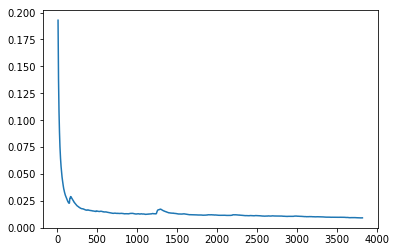

In [51]:
learn.sched.plot_loss()

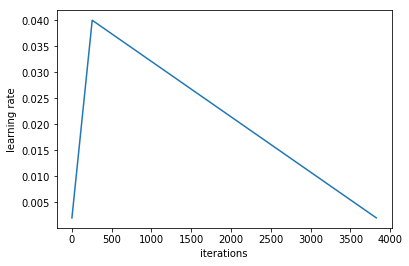

In [52]:
learn.sched.plot_lr()

In [53]:
learn.save('512urn-tmp-2')

**Analysis of result**

You can see the dice coefficients really going up. So notice above, I'm loading in the 128x128 version of the network. We are doing this progressive resizing trick again, so that gets us .99.

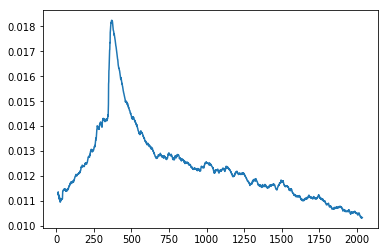

In [82]:
learn.sched.plot_loss()

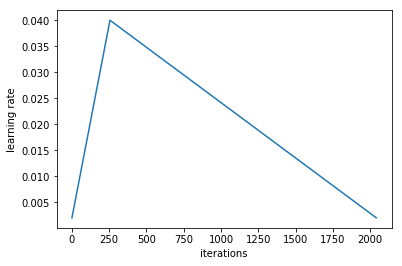

In [83]:
learn.sched.plot_lr()

In [84]:
learn.save('512urn-tmp-1')

In [54]:
learn.unfreeze()
learn.bn_freeze(True)

In [35]:
learn.load('512urn-tmp-1')

In [87]:
%time learn.fit(lrs / 4, 1, wds=wd, cycle_len=15, use_clr=(20, 8), callbacks=[notif_cb])

epoch      trn_loss   val_loss   <lambda>   dice               
    0      0.009964   0.010649   0.995745   0.990278  
    1      0.132006   0.362175   0.862208   0.585182          
    2      0.516      0.312295   0.874892   0.631426         
    3      0.290018   0.294947   0.883492   0.660081         
    4      0.336798   0.29943    0.89267    0.68686          
    5      0.27625    0.302274   0.892094   0.697892         
    6      0.269354   0.286339   0.89665    0.704224         
    7      0.271042   0.289942   0.897454   0.711871         
    8      0.265403   0.279778   0.896851   0.70337          
    9      0.26184    0.276587   0.895839   0.702342         
    10     0.261705   0.276675   0.893665   0.692959         
    11     0.254528   0.275404   0.89393    0.697658         
    12     0.257215   0.273388   0.898357   0.71184          
    13     0.253628   0.272932   0.897442   0.705203         
    14     0.254569   0.27262    0.899495   0.715043         
CPU times: u

[array([0.27262]), 0.8994949545179095, 0.7150428742613784]

In [96]:
learn.save('512urn-0')

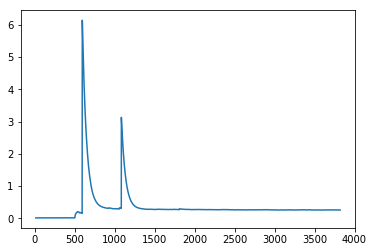

In [93]:
learn.sched.plot_loss()

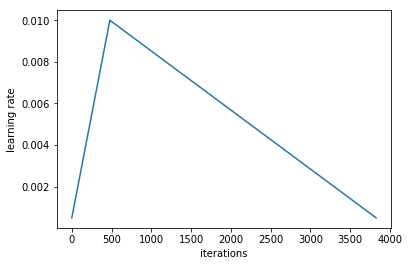

In [94]:
learn.sched.plot_lr()

The training didn't converge! So, I re-train with everything the same.

In [102]:
learn.load('512urn-tmp-1')

In [36]:
%time learn.fit(lrs / 4, 1, wds=wd, cycle_len=8, use_clr=(20, 8), callbacks=[notif_cb])

epoch      trn_loss   val_loss   <lambda>   dice               
    0      0.292876   0.234851   0.94759    0.864297  
    1      0.021715   0.017444   0.992912   0.983867          
    2      0.015391   0.014765   0.993905   0.986388          
    3      0.014186   0.013977   0.994445   0.987204          
    4      0.013735   0.013587   0.994509   0.987571          
    5      0.013473   0.013406   0.994538   0.9877            
    6      0.013243   0.013222   0.994624   0.9879            
    7      0.013002   0.013129   0.994768   0.988011          

CPU times: user 54min 24s, sys: 5min 25s, total: 59min 49s
Wall time: 46min 34s


[array([0.01313]), 0.9947682297418988, 0.9880109072188193]

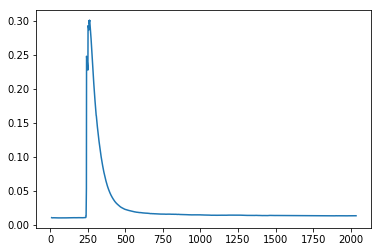

In [37]:
learn.sched.plot_loss()

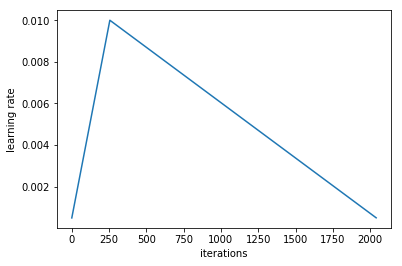

In [38]:
learn.sched.plot_lr()

In [39]:
learn.save('512urn-1')

In [55]:
learn.load('512urn-tmp-2')

In [57]:
%time learn.fit(lrs / 4, 1, wds=wd, cycle_len=10, use_clr=(20, 10), callbacks=[notif_cb])

epoch      trn_loss   val_loss   <lambda>   dice               
    0      0.009372   0.010585   0.995743   0.990435  
    1      0.009201   0.009934   0.995893   0.990923           
    2      0.022731   0.014535   0.994104   0.986531           
    3      0.012456   0.012546   0.994909   0.988559          
    4      0.011394   0.011722   0.995429   0.989384          
    5      0.010975   0.011325   0.995433   0.989744          
    6      0.010621   0.011133   0.995728   0.990007          
    7      0.010379   0.011007   0.995749   0.990243          
    8      0.010233   0.010774   0.995854   0.990384          
    9      0.010275   0.010706   0.995858   0.990412          

CPU times: user 1h 8min 16s, sys: 6min 22s, total: 1h 14min 39s
Wall time: 57min 48s


[array([0.01071]), 0.9958578631991432, 0.99041168513311]

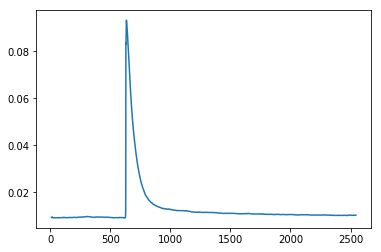

In [58]:
learn.sched.plot_loss()

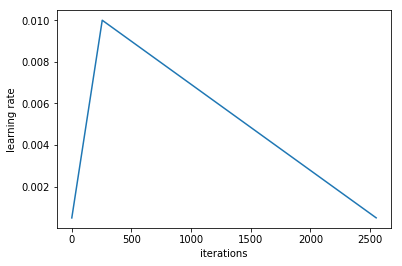

In [59]:
learn.sched.plot_lr()

**Analysis of result**

The unfreeze doesn't get to .994.

In [61]:
learn.save('512urn-2')

In [62]:
learn.load('512urn-2')

In [63]:
x, y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

And you can see, it's now looking pretty good.

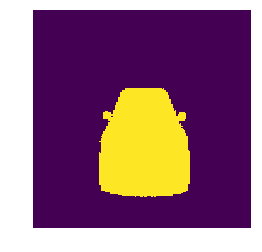

In [64]:
show_img(py[0] > 0)

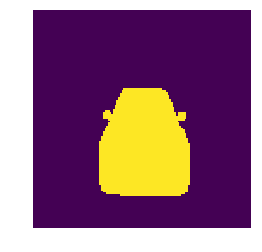

In [65]:
show_img(y[0])

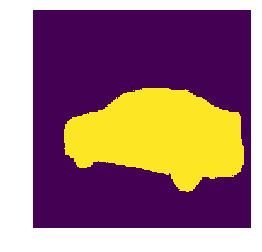

In [70]:
show_img(py[5] > 0)

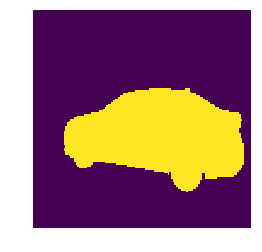

In [71]:
show_img(y[5])

In [72]:
m.close()

## 1024x1024

Go down to a batch size of 4, size of 1024.

In [81]:
sz = 1024
bs = 4

In [82]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [83]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [84]:
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = nn.BCEWithLogitsLoss()
learn.metrics = [accuracy_thresh(0.5), dice]

Load in what we just saved with the 512.

In [85]:
learn.load('512urn-2')

In [86]:
learn.freeze_to(1)

In [87]:
lr

0.04

In [88]:
%time learn.fit(lr, 1, wds=wd, cycle_len=2, use_clr=(5, 4))

epoch      trn_loss   val_loss   <lambda>   dice                
    0      0.013102   0.013132   0.994931   0.988265  
    1      0.010119   0.011204   0.99575    0.989929            

CPU times: user 45min 17s, sys: 6min 50s, total: 52min 8s
Wall time: 45min 6s


[array([0.0112]), 0.9957499636544122, 0.9899293804994912]

In [89]:
learn.save('1024urn-tmp')

In [90]:
learn.load('1024urn-tmp')

In [91]:
learn.unfreeze()
learn.bn_freeze(True)

In [92]:
lrs = np.array([lr / 200, lr / 30, lr])
lrs

array([0.0002 , 0.00133, 0.04   ])

In [93]:
%time learn.fit(lrs / 10, 1, wds=wd, cycle_len=4, use_clr=(20, 8), callbacks=[notif_cb])

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.008753   0.010227   0.996026   0.990752  
    1      0.008583   0.009887   0.996214   0.990971             
    2      0.008157   0.009736   0.996149   0.991187             
    3      0.008089   0.00963    0.996239   0.991263             

CPU times: user 1h 53min, sys: 13min 28s, total: 2h 6min 28s
Wall time: 1h 52min 36s


[array([0.00963]), 0.9962390765311226, 0.9912625075008968]

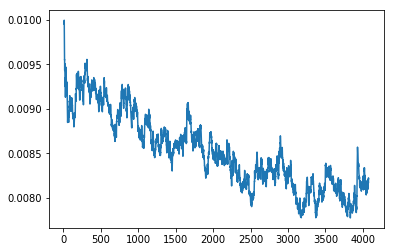

In [94]:
learn.sched.plot_loss()

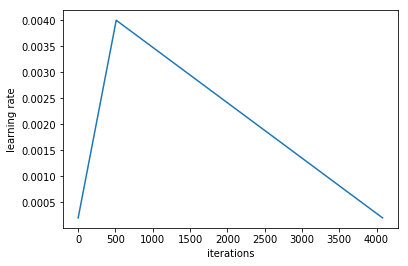

In [95]:
learn.sched.plot_lr()

In [96]:
learn.save('1024urn-0')

In [98]:
%time learn.fit(lrs / 10, 1, wds=wd, cycle_len=4, use_clr=(20, 8), callbacks=[notif_cb])

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.008318   0.009903   0.996072   0.991031  
    1      0.008046   0.009467   0.996279   0.991389             
    2      0.007842   0.009408   0.99639    0.991476             
    3      0.00743    0.00936    0.996377   0.991522             

CPU times: user 1h 52min 46s, sys: 13min 25s, total: 2h 6min 11s
Wall time: 1h 52min 24s


[array([0.00936]), 0.9963768663860503, 0.9915224222062244]

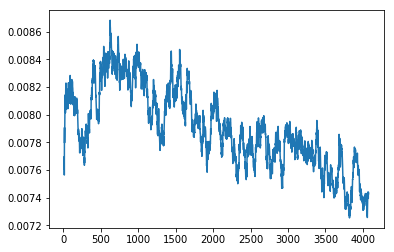

In [99]:
learn.sched.plot_loss()

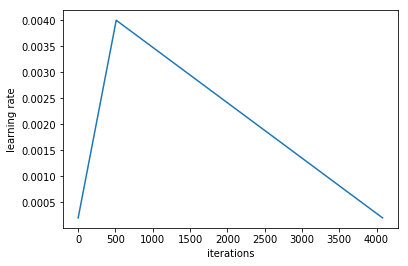

In [100]:
learn.sched.plot_lr()

In [101]:
learn.save('1024urn')

In [102]:
learn.load('1024urn')

In [103]:
x, y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

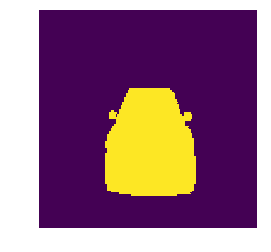

In [104]:
show_img(py[0] > 0)

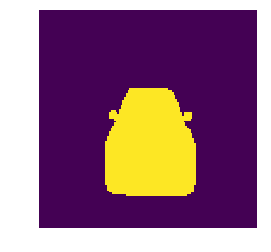

In [105]:
show_img(y[0])

As you can see, that actually looks not bad. In accuracy terms, 99.64%. You can see this is looking like something you could almost just about use to cut out. I think, at this point, there's a couple of minor tweaks we can do to get up to .997 but really the key thing then, I think, is just maybe to do a few bit of smoothing maybe or a little bit of post-processing. You can go and have a look at the Carvana winners' blogs and see some of these tricks, but as I say, the difference between where we are at .996 and what the winners got of .997, it's not heaps. So really that just the U-Net on its own pretty much solves that problem.